## Assignment2: Practical Data Science with Python

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc

# Retrieving Mice Protein Expression Dataset

In [2]:
mice_data = pd.read_csv("Data_Cortex_Nuclear.csv", index_col = 0)
print("Retrieving the data...")
print("Retrieved data has " + str(mice_data.shape[0]) +" observations and " + str(mice_data.shape[1]) + " features")
mice_data.head()

Retrieving the data...
Retrieved data has 1080 observations and 81 features


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


# Exploring and Preparing the data

In [3]:
mice_data = mice_data.reset_index(drop=True)
mice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 81 columns):
DYRK1A_N           1077 non-null float64
ITSN1_N            1077 non-null float64
BDNF_N             1077 non-null float64
NR1_N              1077 non-null float64
NR2A_N             1077 non-null float64
pAKT_N             1077 non-null float64
pBRAF_N            1077 non-null float64
pCAMKII_N          1077 non-null float64
pCREB_N            1077 non-null float64
pELK_N             1077 non-null float64
pERK_N             1077 non-null float64
pJNK_N             1077 non-null float64
PKCA_N             1077 non-null float64
pMEK_N             1077 non-null float64
pNR1_N             1077 non-null float64
pNR2A_N            1077 non-null float64
pNR2B_N            1077 non-null float64
pPKCAB_N           1077 non-null float64
pRSK_N             1077 non-null float64
AKT_N              1077 non-null float64
BRAF_N             1077 non-null float64
CAMKII_N           1077 non-null

In [4]:
# convert all the data to lowercase letters
mice_data = mice_data.applymap(lambda x: x.lower() if type(x) is str else x)

# remove any extra whitespace from the data
mice_data = mice_data.applymap(lambda x: x.strip() if type(x) is str else x)

In [5]:
# check for any typo errors
for column in ['Genotype', 'Treatment', 'Behavior', 'class']:
    print(mice_data[column].value_counts())
    print("\n")

control    570
ts65dn     510
Name: Genotype, dtype: int64


memantine    570
saline       510
Name: Treatment, dtype: int64


s/c    555
c/s    525
Name: Behavior, dtype: int64


c-cs-m    150
c-sc-m    150
c-cs-s    135
t-sc-s    135
t-sc-m    135
t-cs-m    135
c-sc-s    135
t-cs-s    105
Name: class, dtype: int64




In [6]:
# replacing 'ts65dn' with 'trisomic' for ease of reading
mice_data['Genotype'].replace('ts65dn', 'trisomic', inplace=True)

In [7]:
# changing datatype from object to categorical
for column in ['Genotype', 'Treatment', 'Behavior', 'class']:
    mice_data[column] = mice_data[column].astype('category')

In [8]:
# filling null values
for column in mice_data.columns:
    if str(mice_data[column].dtype) is not 'category':
        mice_data[column].fillna(np.mean(mice_data[column]), inplace = True)
    else:
        mice_data[column].fillna(mice_data[column].value_counts().argmax(), inplace = True)

In [9]:
# sanity check for numerical features
mice_data.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249015,0.251290,0.049314,0.346810,0.931802,0.041577,0.027004,1.293368,0.032542,0.466254,...,0.028989,0.026461,0.023519,0.014276,0.023018,0.066432,0.054222,0.036261,0.048069,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288163,0.473669,0.287650,2.059152,3.160287,0.205821,0.164619,2.479861,0.190828,1.206389,...,0.206395,0.141045,0.119986,0.110839,0.114373,0.398082,0.133969,0.159168,0.174271,1.081423
50%,0.366540,0.566365,0.316703,2.297269,3.763306,0.231246,0.182270,3.329624,0.210681,1.356368,...,0.224000,0.157914,0.134762,0.121626,0.128466,0.448459,0.169609,0.183135,0.205440,1.317441
75%,0.487574,0.697500,0.348039,2.528035,4.425107,0.257225,0.197226,4.480652,0.234558,1.560931,...,0.241655,0.167584,0.139331,0.131955,0.142427,0.490773,0.187174,0.196133,0.219242,1.585824
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.358289,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791


In [10]:
# sanity check for categorical features
mice_data.describe(include = ['category'])

,Genotype,Treatment,Behavior,class
count,1080,1080,1080,1080
unique,2,2,2,8
top,control,memantine,s/c,c-sc-m
freq,570,570,555,150


In [11]:
# detecting outliers
print("-----------------------------------------")
print("Detecting outliers")
print("-----------------------------------------")

str1 =""
for column in mice_data.columns:
    if str(mice_data[column].dtype) is not 'category':
        mean = mice_data[column].mean()
        sd = mice_data[column].std()
        median = mice_data[column].median()
        counter = 0
        row = -1
        for i in mice_data[column]:
            row += 1
            if (i <  mean - 3 * sd) | (i > mean + 3 * sd):
                counter += 1
                #mice_data.at[row, column] = mean
        str1 = "No of Outliers in " + str(column) + ": " + str(counter) +  "\n"
        print(str1)

-----------------------------------------
Detecting outliers
-----------------------------------------
No of Outliers in DYRK1A_N: 15

No of Outliers in ITSN1_N: 15

No of Outliers in BDNF_N: 3

No of Outliers in NR1_N: 2

No of Outliers in NR2A_N: 4

No of Outliers in pAKT_N: 9

No of Outliers in pBRAF_N: 8

No of Outliers in pCAMKII_N: 1

No of Outliers in pCREB_N: 1

No of Outliers in pELK_N: 20

No of Outliers in pERK_N: 14

No of Outliers in pJNK_N: 7

No of Outliers in PKCA_N: 0

No of Outliers in pMEK_N: 8

No of Outliers in pNR1_N: 3

No of Outliers in pNR2A_N: 5

No of Outliers in pNR2B_N: 5

No of Outliers in pPKCAB_N: 1

No of Outliers in pRSK_N: 7

No of Outliers in AKT_N: 4

No of Outliers in BRAF_N: 15

No of Outliers in CAMKII_N: 7

No of Outliers in CREB_N: 7

No of Outliers in ELK_N: 15

No of Outliers in ERK_N: 5

No of Outliers in GSK3B_N: 16

No of Outliers in JNK_N: 8

No of Outliers in MEK_N: 3

No of Outliers in TRKA_N: 3

No of Outliers in RSK_N: 8

No of Outlie

# Univariate Exploration

In [12]:
# this function plots the frequency distribution of a categorical feature
def show_frequency_distribution(feature_name, feature_values):
    freq = (feature_name.value_counts() ).sort_index()
    df = pd.DataFrame((feature_name.value_counts()).sort_index())
    bars = feature_values
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1, 2, 1)
    y = np.arange(len(bars))
    _ = plt.bar(freq.index, freq , color = 'salmon');
    _ = plt.xticks(freq.index, bars, rotation = 45);
    _ = plt.ylabel("Frequency count");
    _ = plt.xlabel(str(feature_name.name) + " type");
    _ = plt.title("Frequency Distribution of " + str(feature_name.name));
    ax2 = fig.add_subplot(1, 2, 2)
    font_size=14
    bbox=[1, 0, 1, 1]
    ax2.axis('off')
    table = ax2.table(cellText = df.values, rowLabels = feature_values, bbox=bbox, colLabels=df.columns)
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    plt.show();

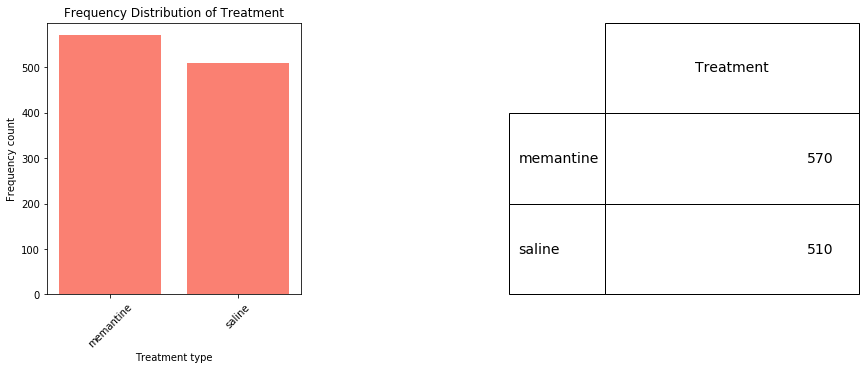

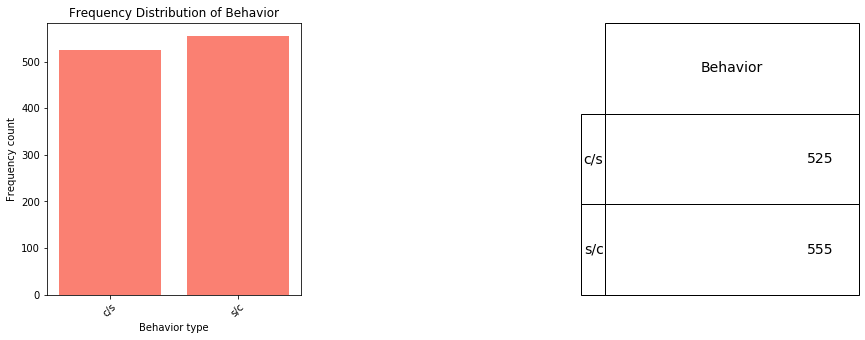

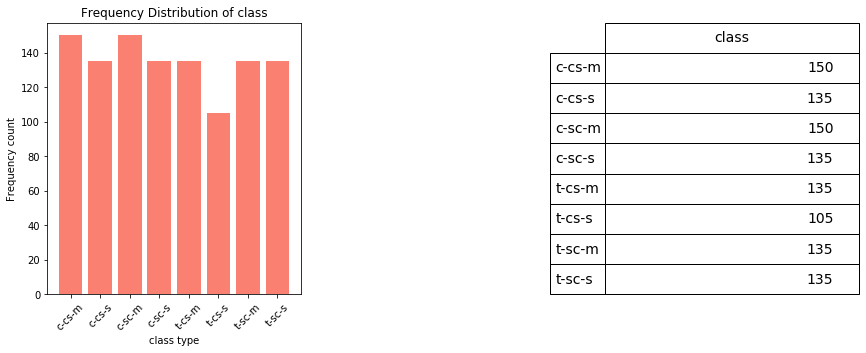

In [13]:
for column in ['Treatment', 'Behavior', 'class']:
    show_frequency_distribution(mice_data[column], list(mice_data[column].value_counts().sort_index().index))

In [14]:
# this function plots a histogram of a numerical feature
def plot_histogram(feature_name):
    plt.figure(figsize=(15,5))
    #upperlimit =  int((mice_data[feature_name].mean() + 3 * mice_data[feature_name].std()))
    avg = round(mice_data[feature_name].mean(), 2)
    sns.distplot(a=mice_data[feature_name], hist=True, kde=True, rug=False, color = 'salmon',bins = 33 )
    plt.axvline(x= avg, label='Average nuclear fraction', c='blue')
    plt.text(x= avg + 0.001, y = 0.0001, s=avg, fontsize = 15 )
    plt.xlim(0,mice_data[feature_name].max())
    plt.title("Histogram for Protein type: '"+ feature_name[:-2]+"'")
    plt.xlabel("Amount of "+ feature_name[:-2] +" protein in nuclear fraction")
    plt.legend()
    plt.ylabel("Frequency")
    plt.show()
    return avg

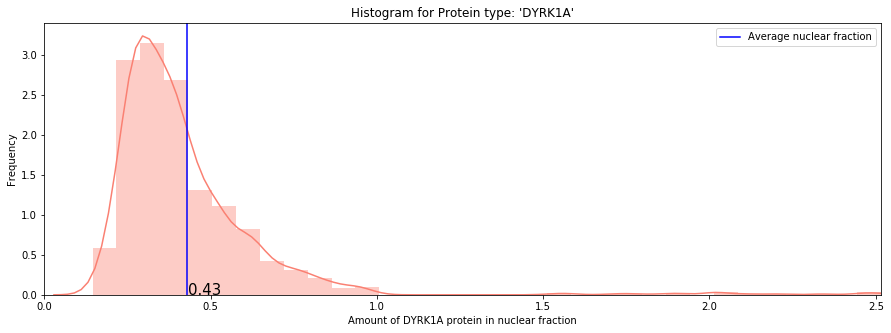

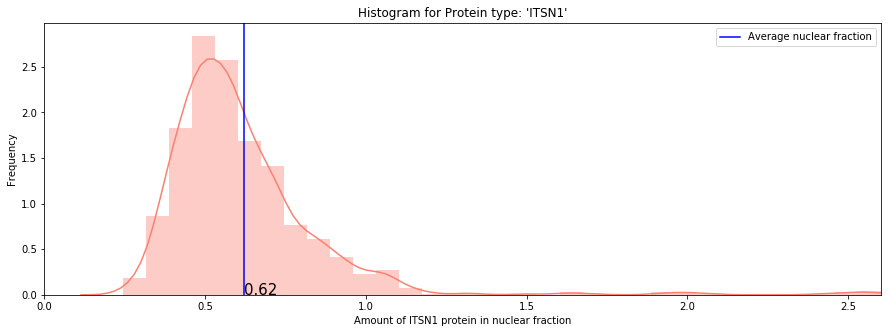

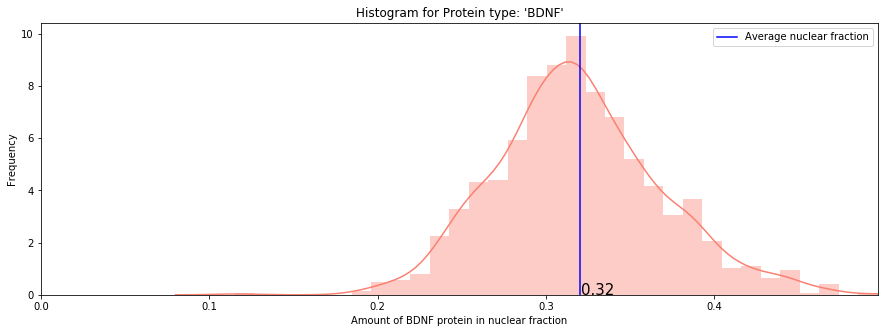

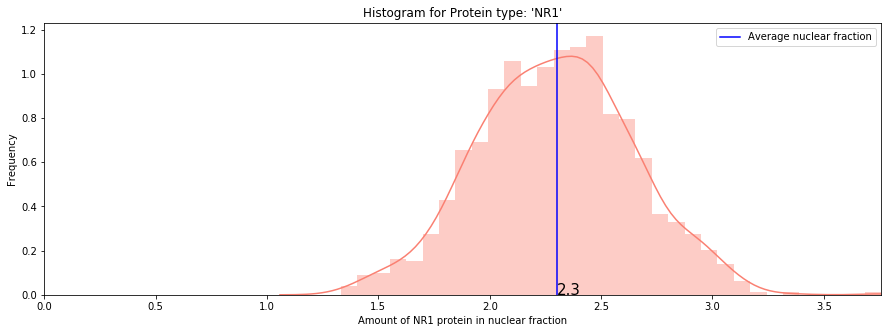

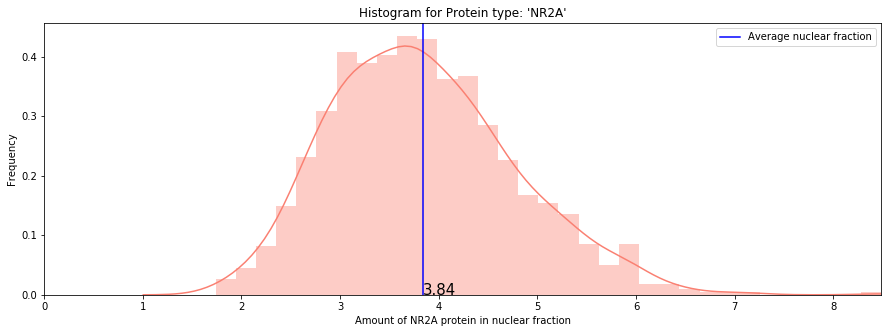

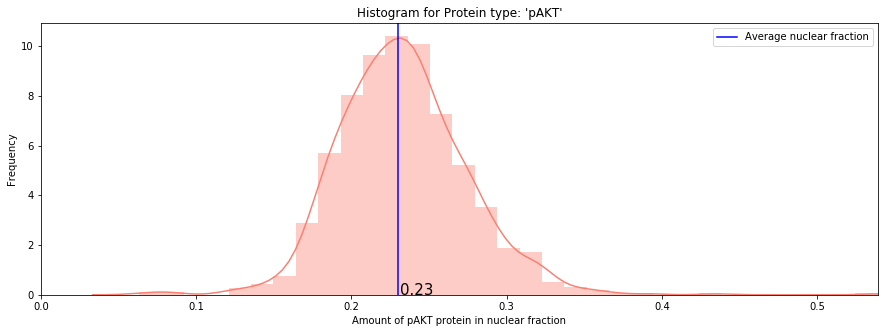

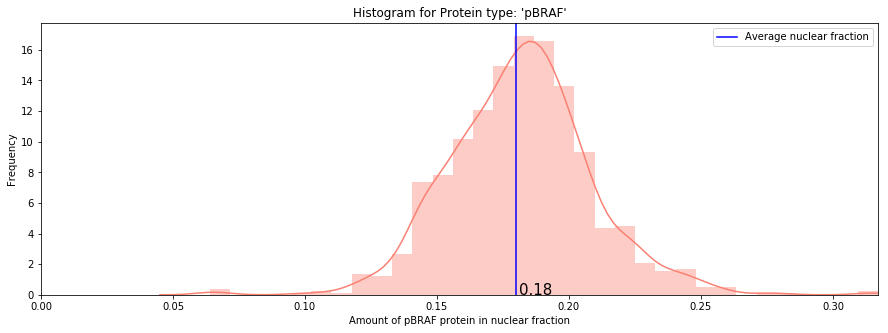

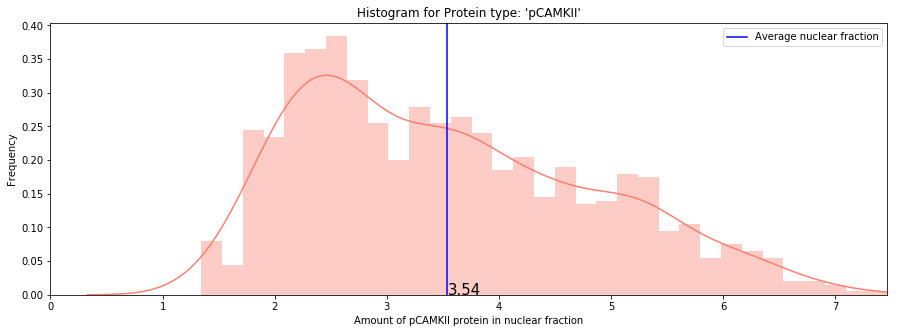

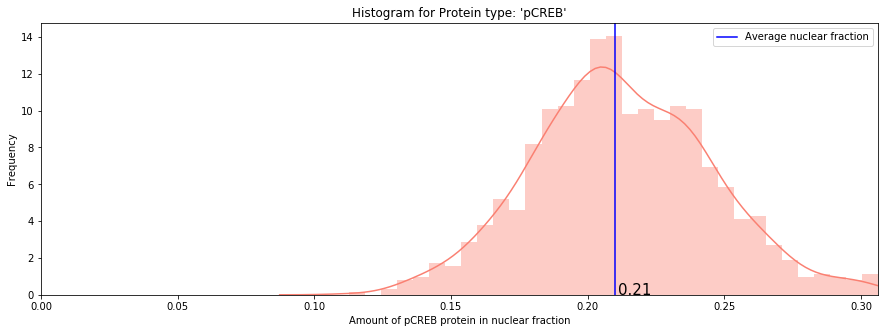

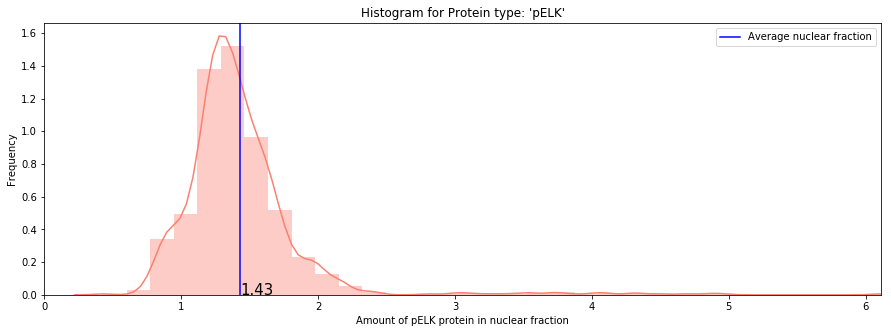

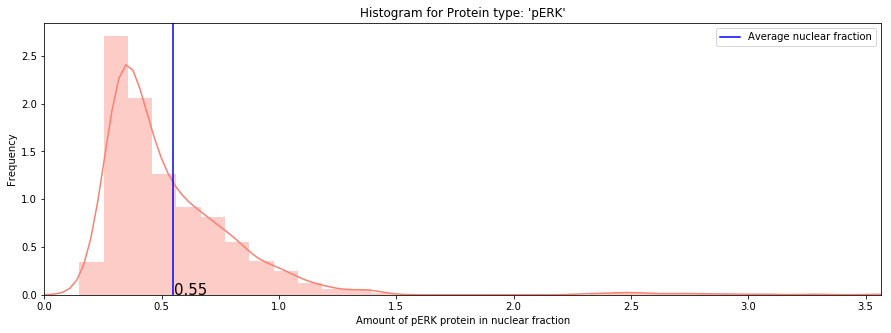

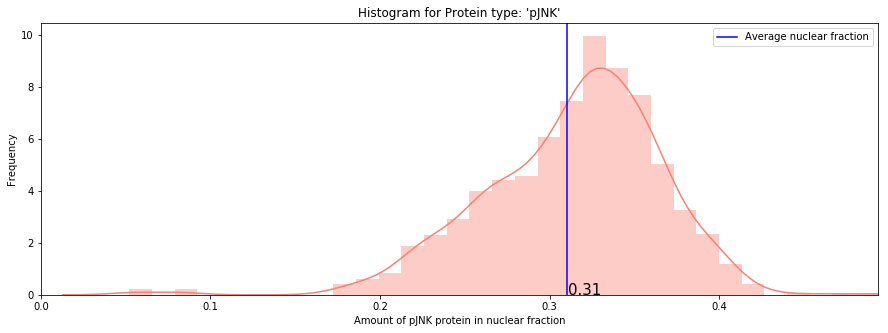

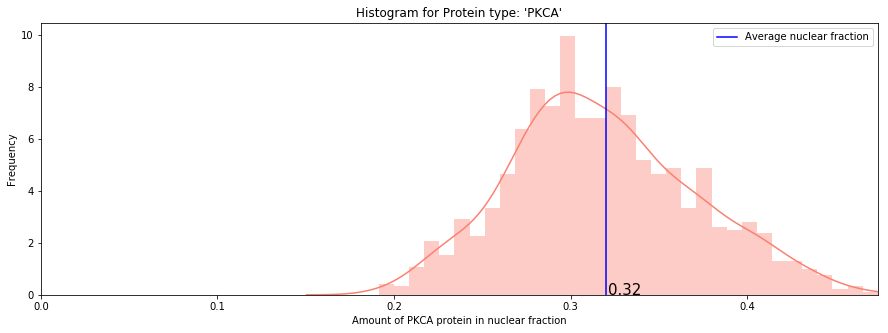

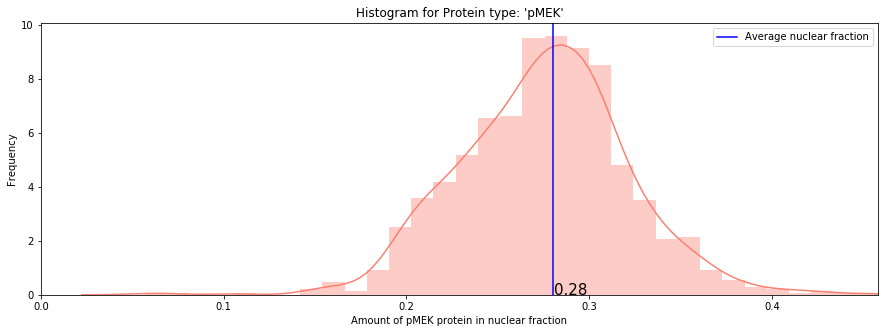

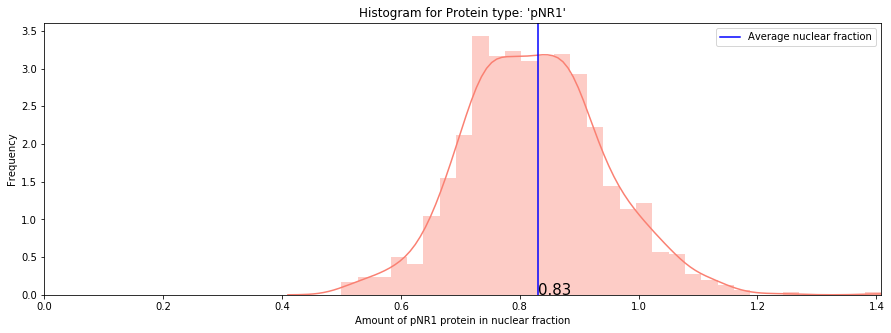

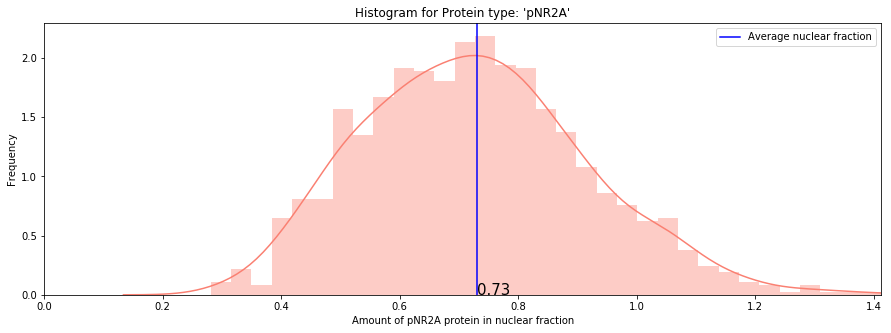

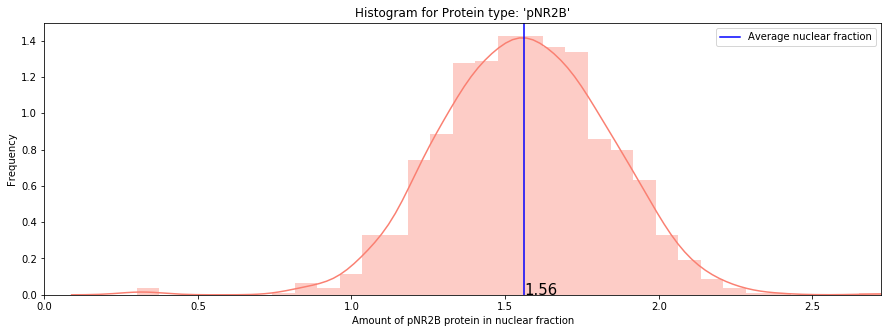

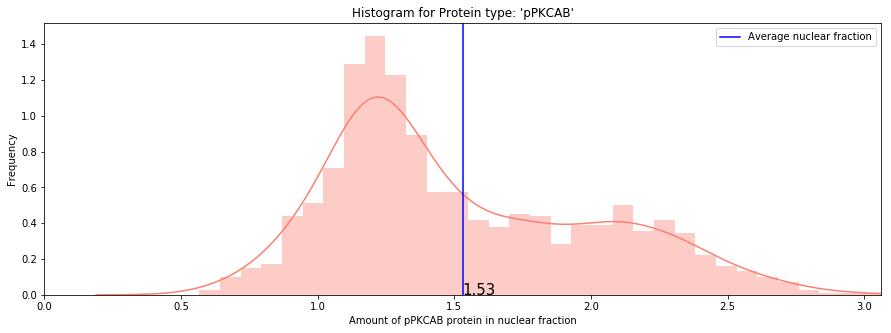

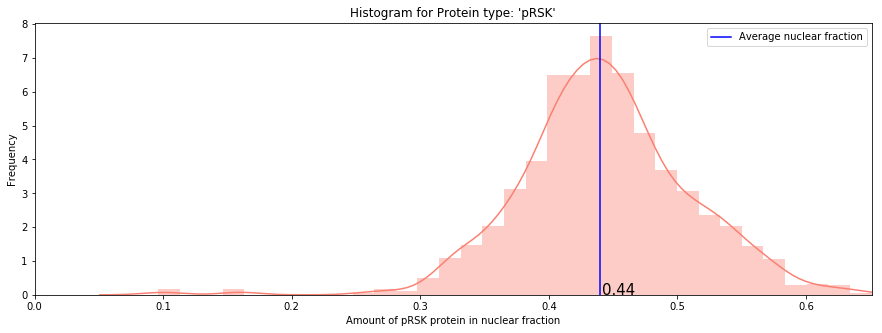

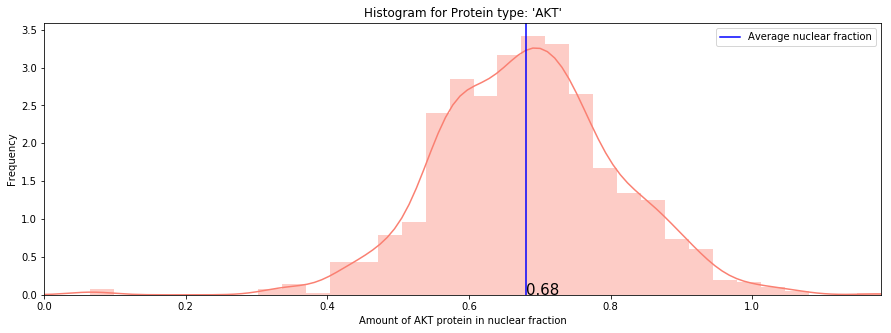

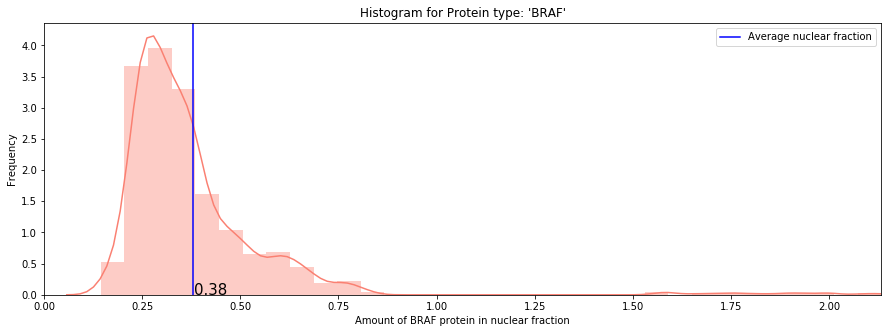

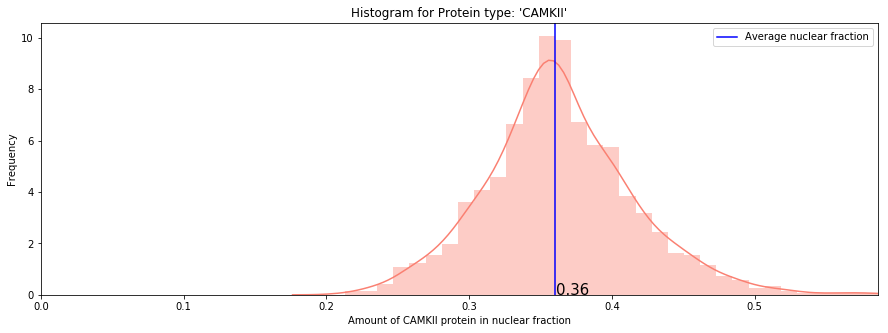

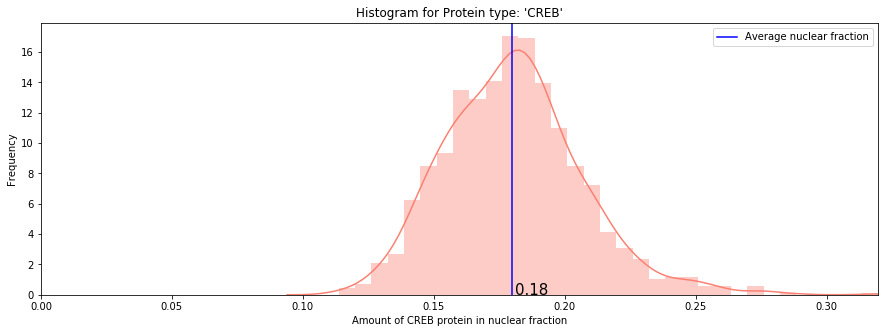

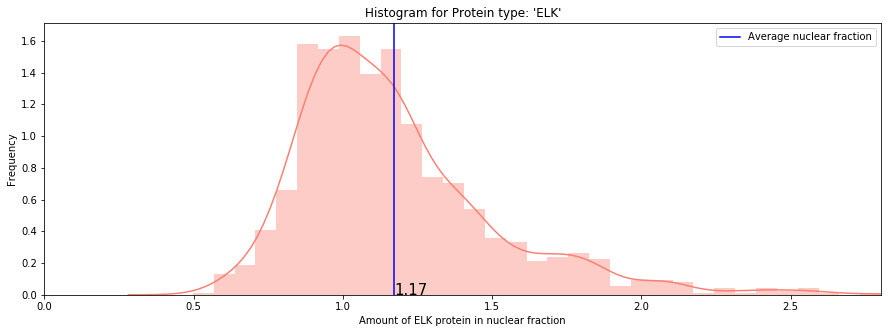

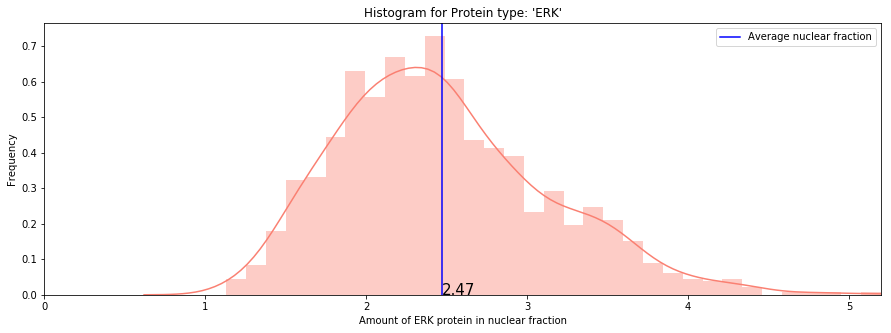

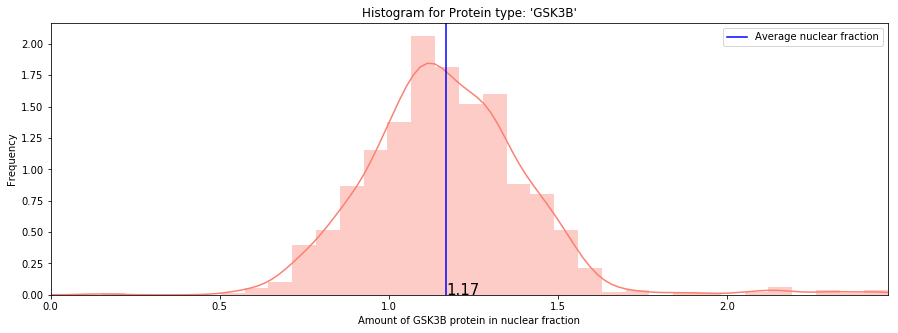

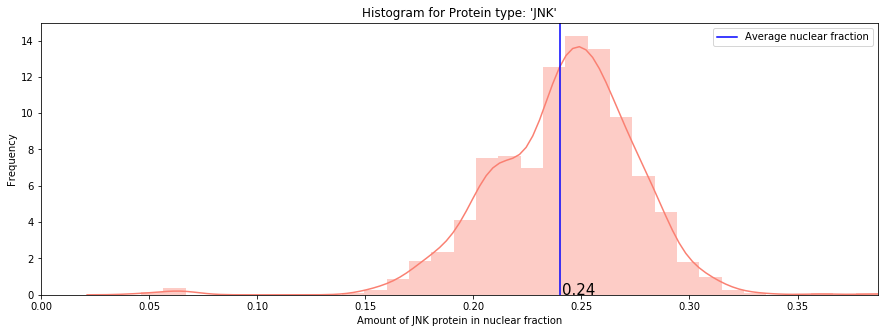

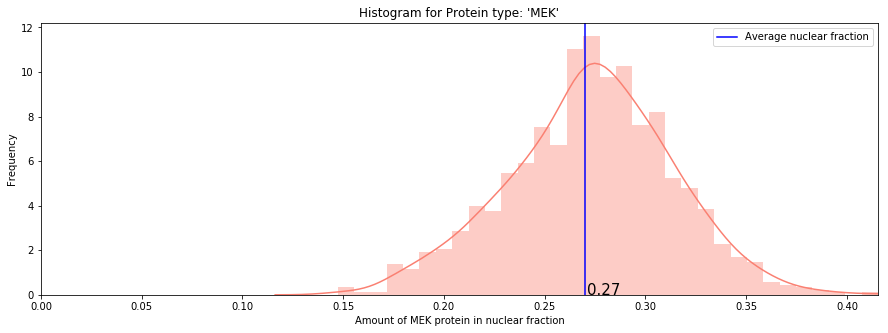

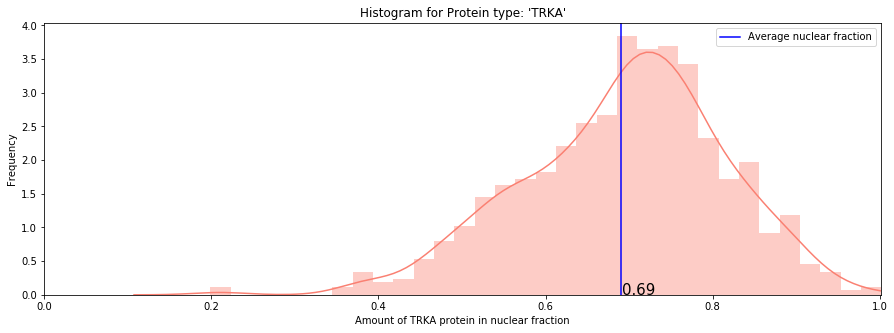

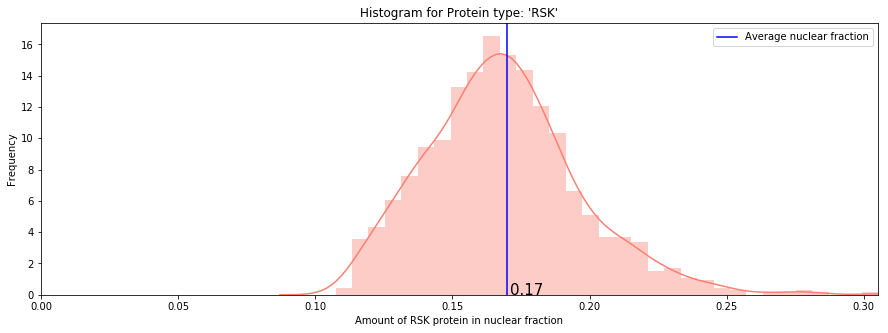

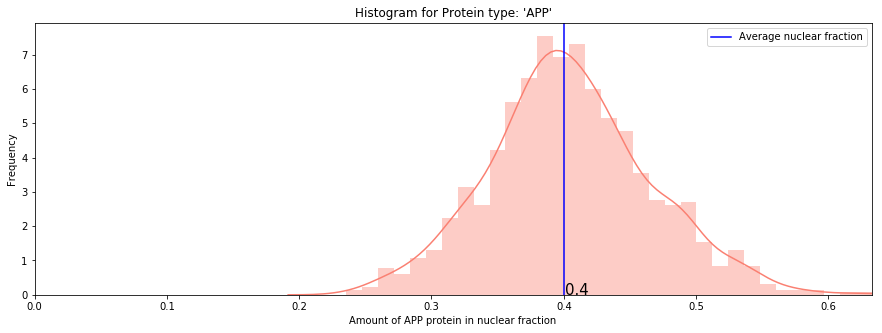

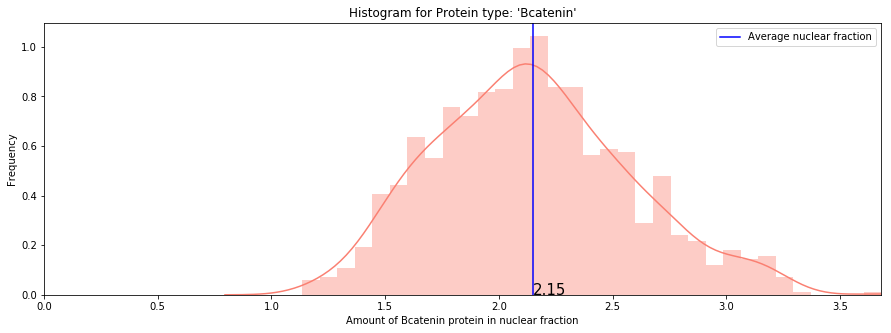

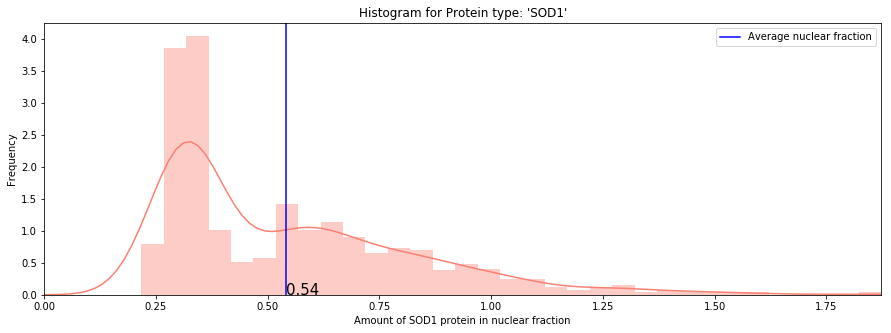

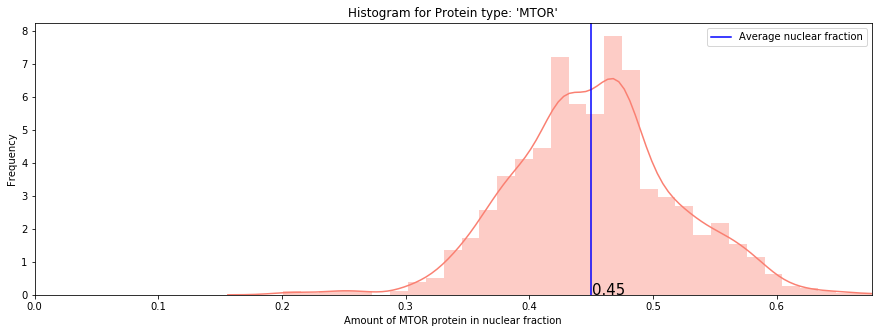

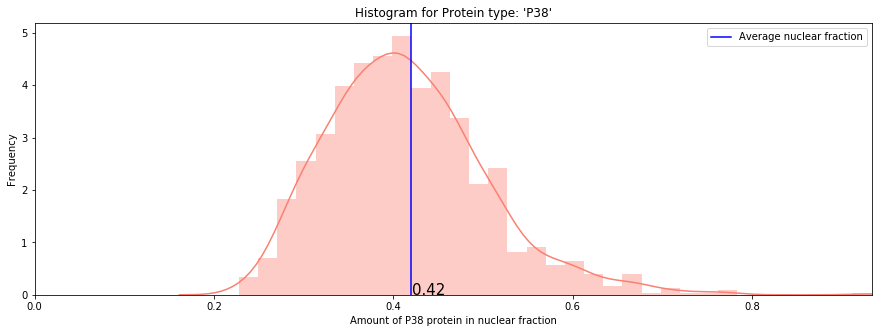

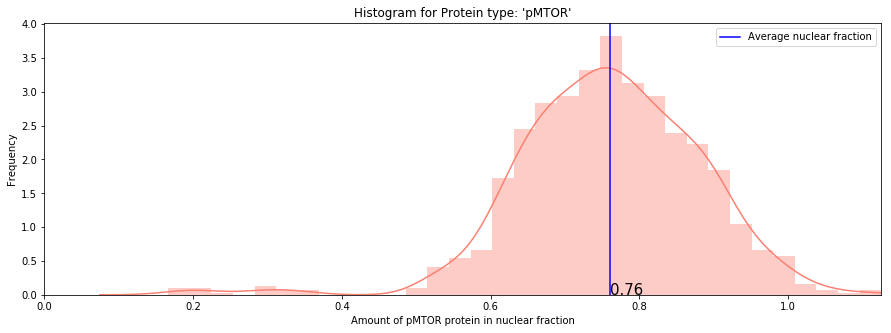

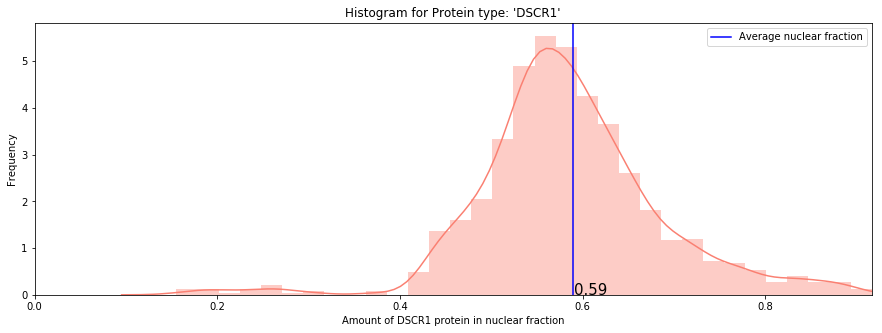

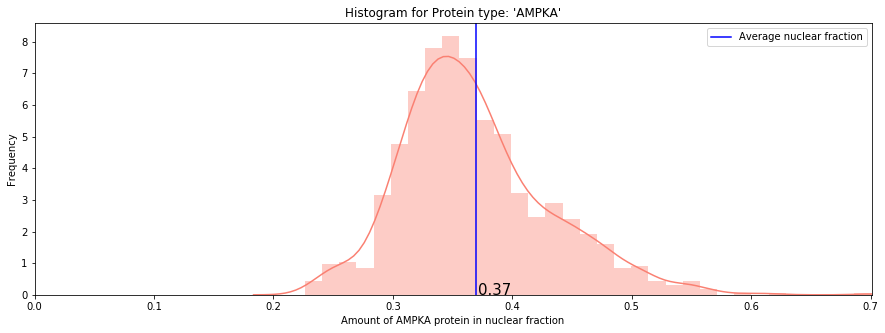

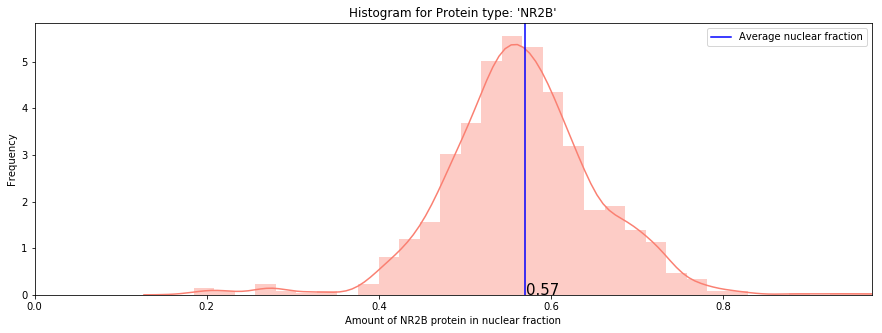

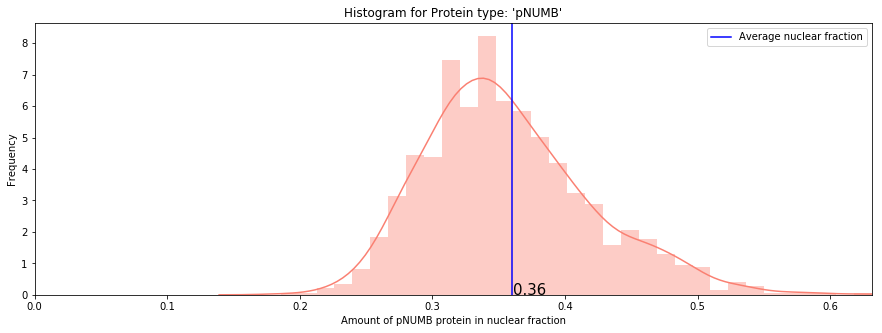

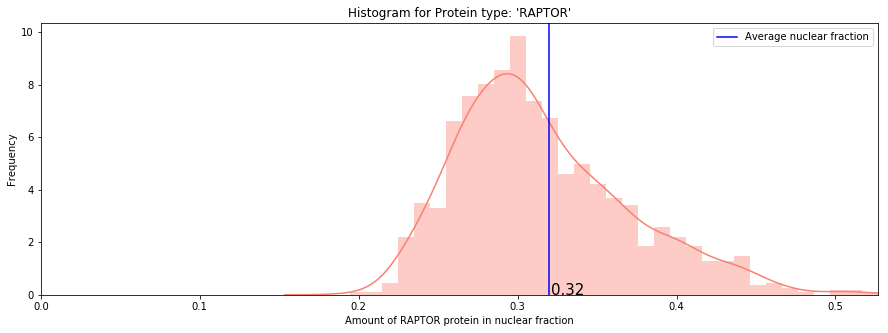

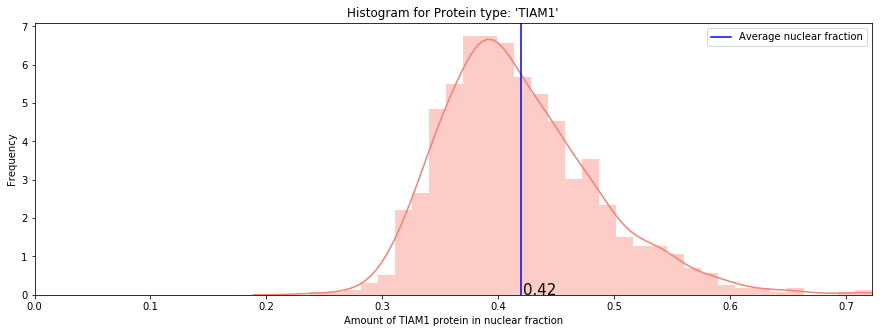

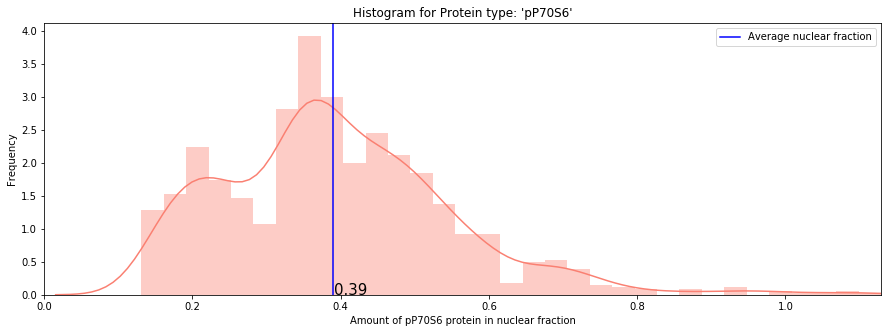

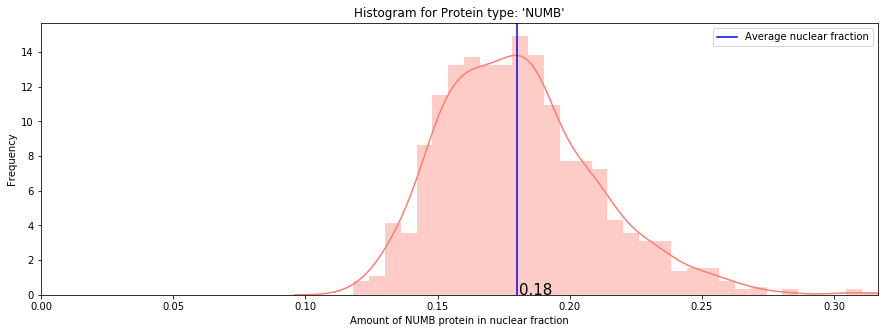

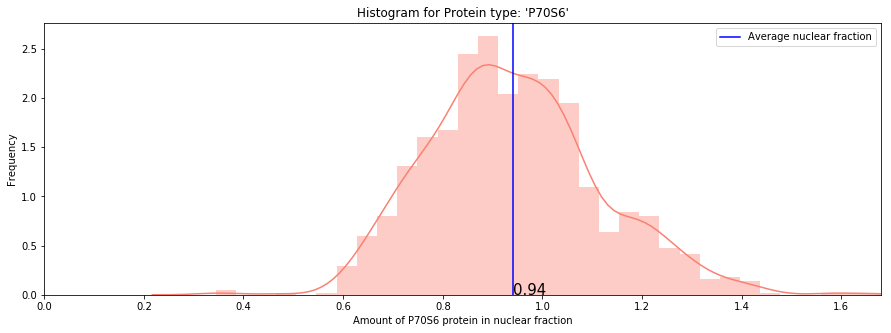

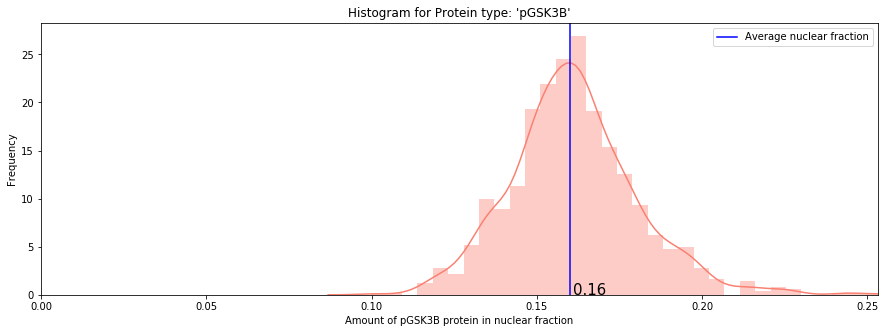

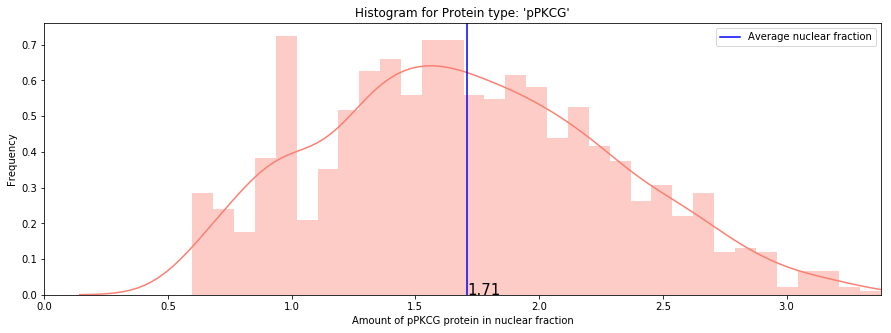

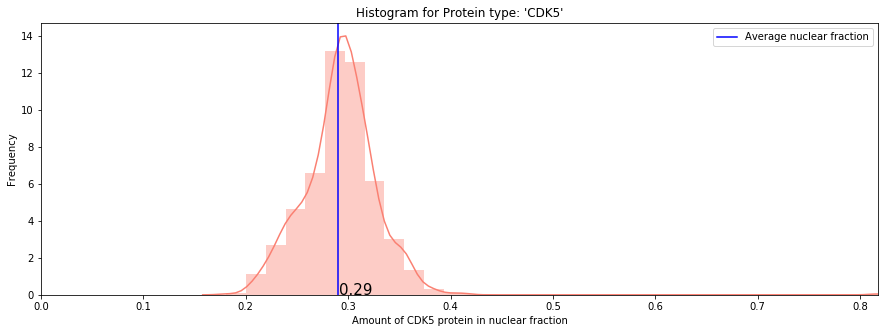

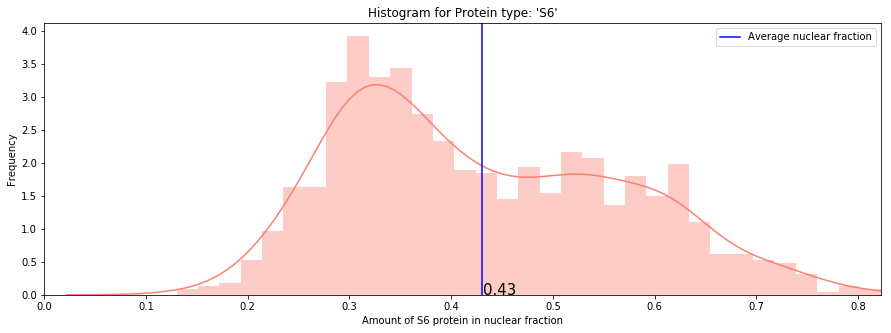

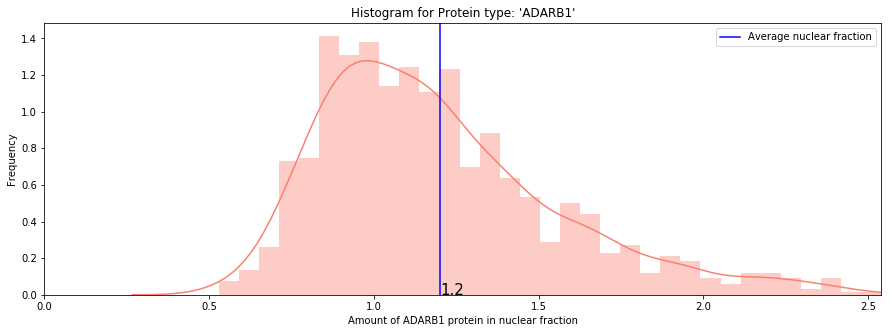

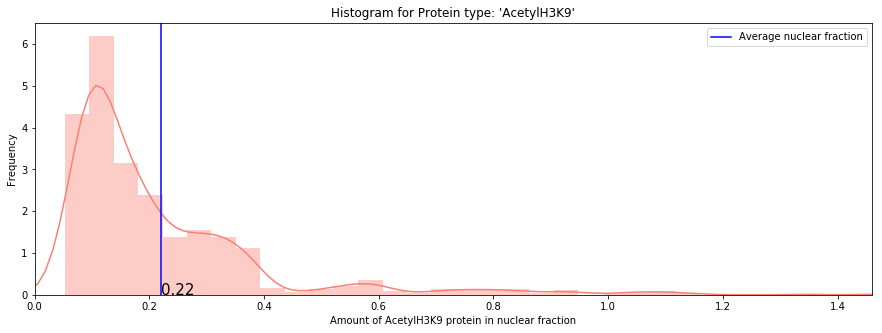

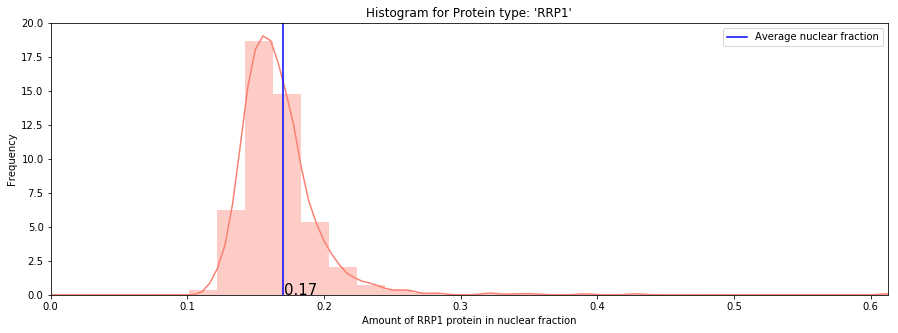

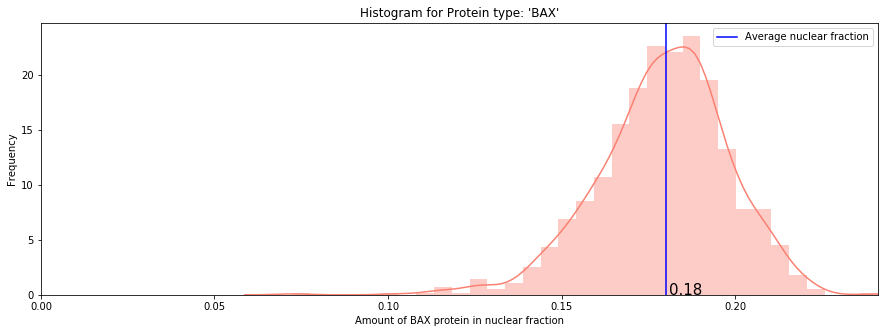

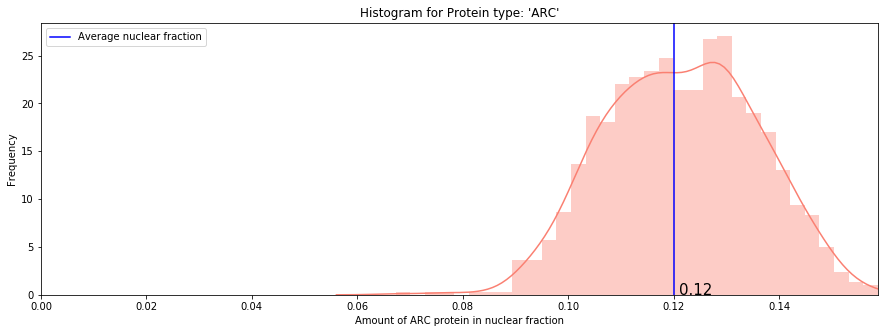

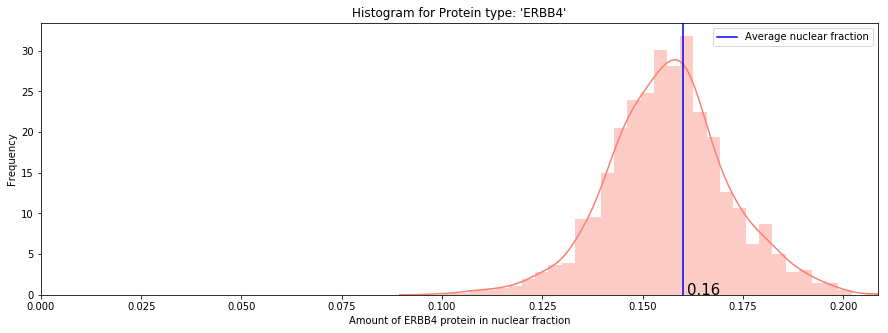

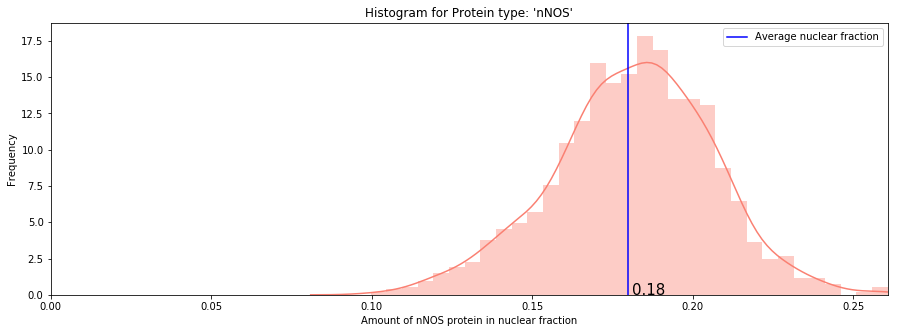

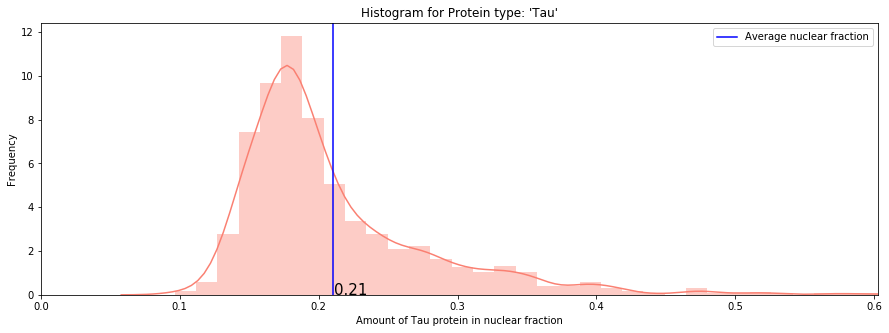

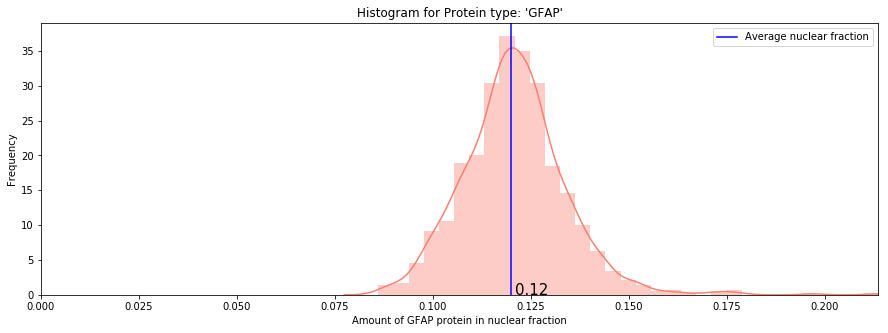

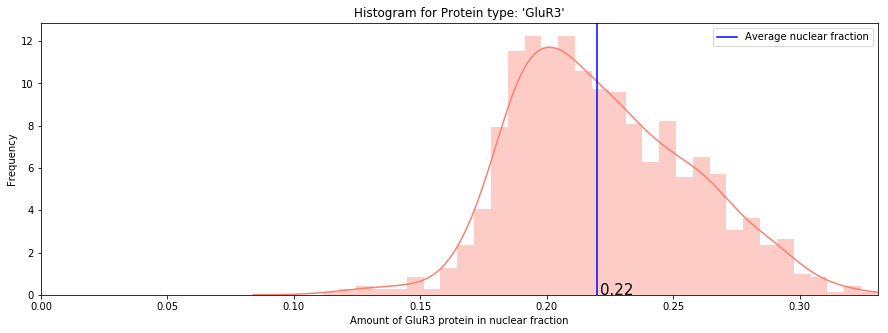

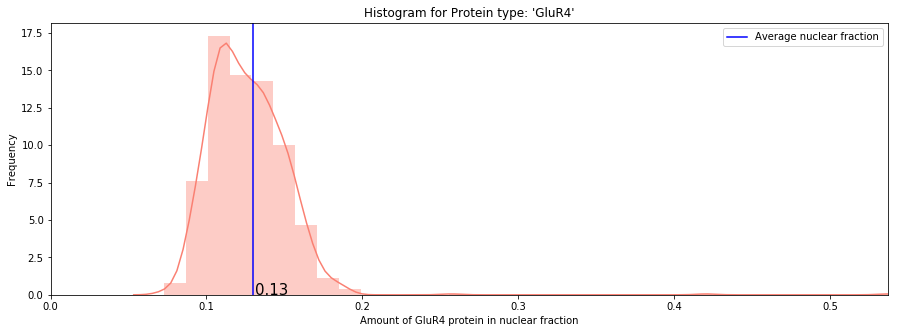

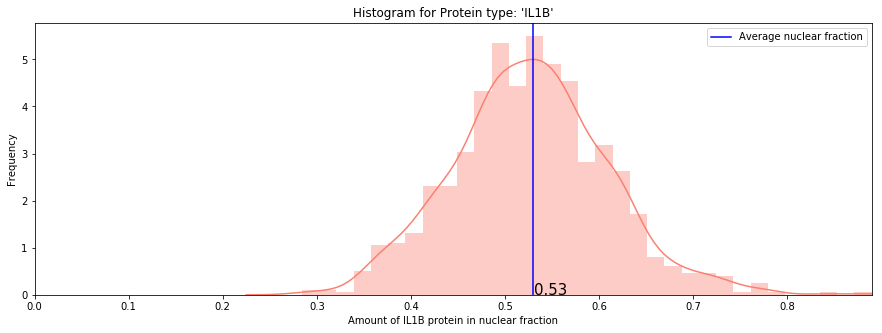

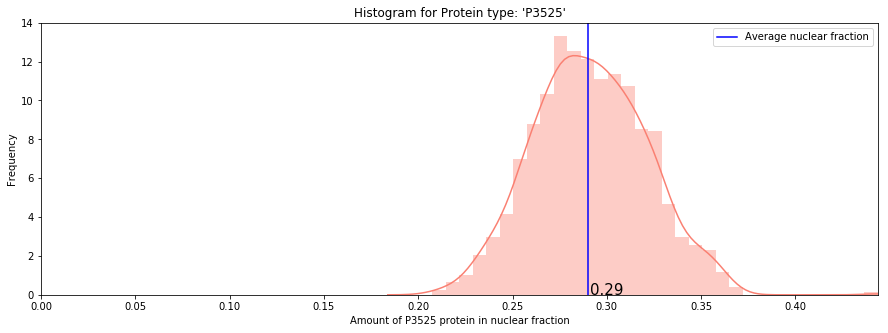

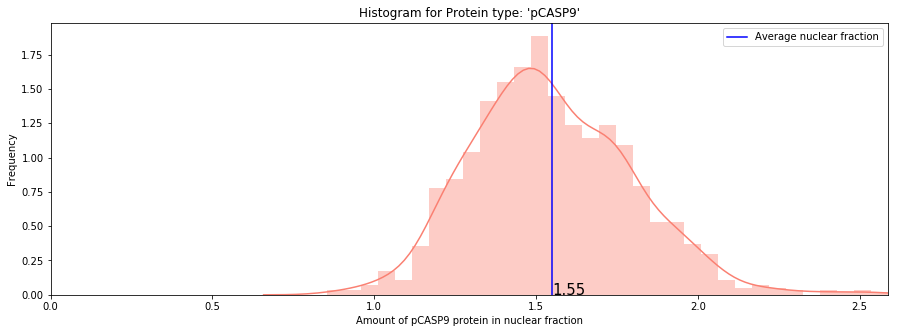

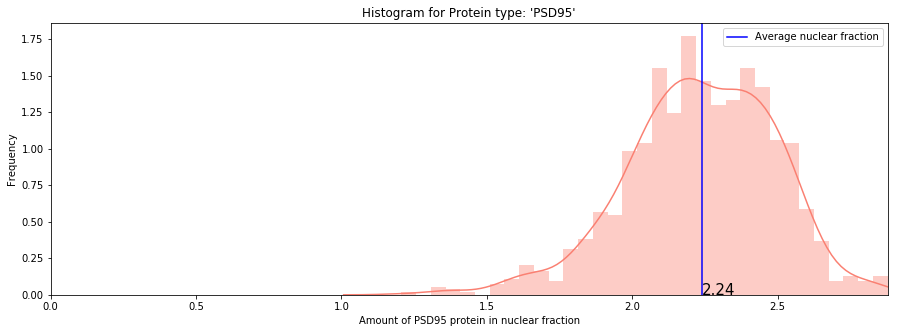

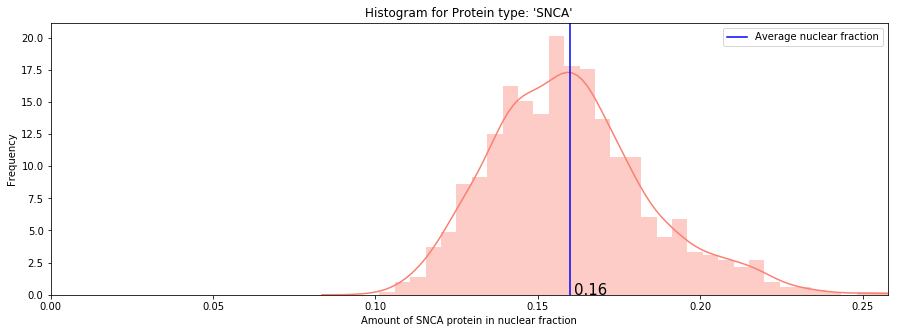

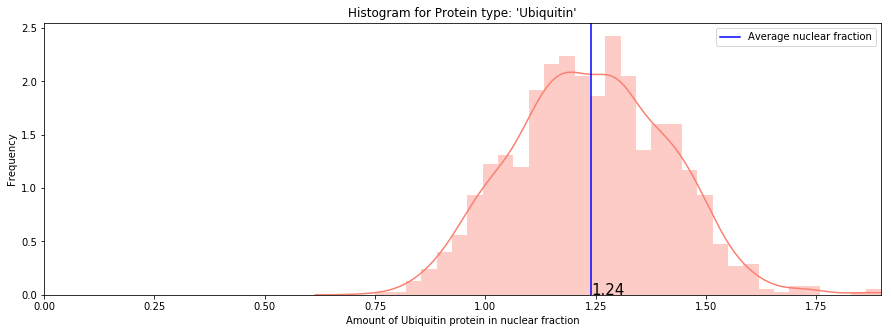

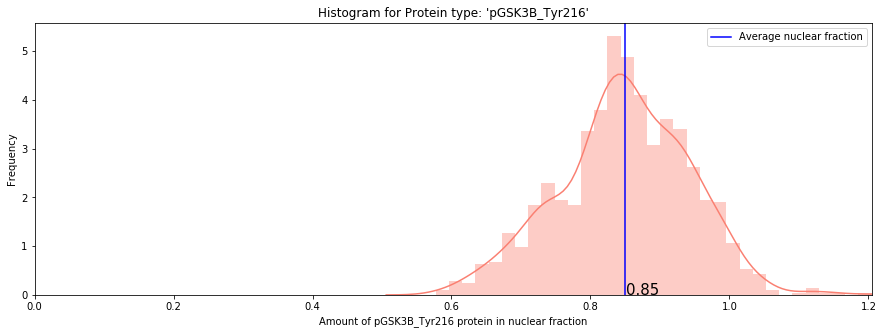

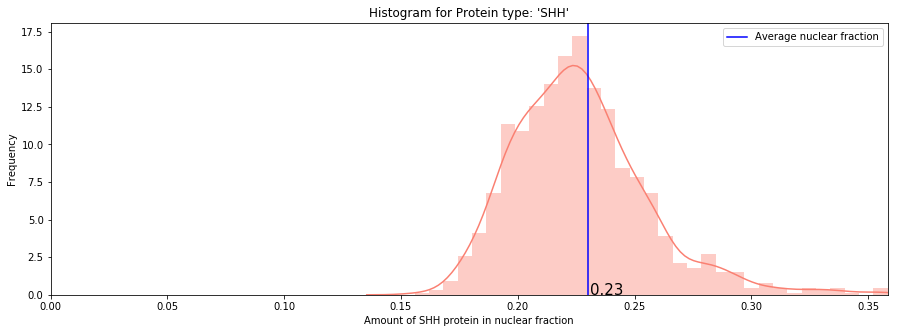

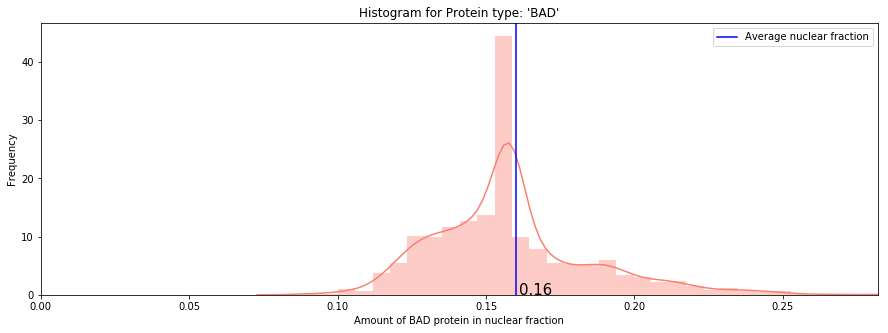

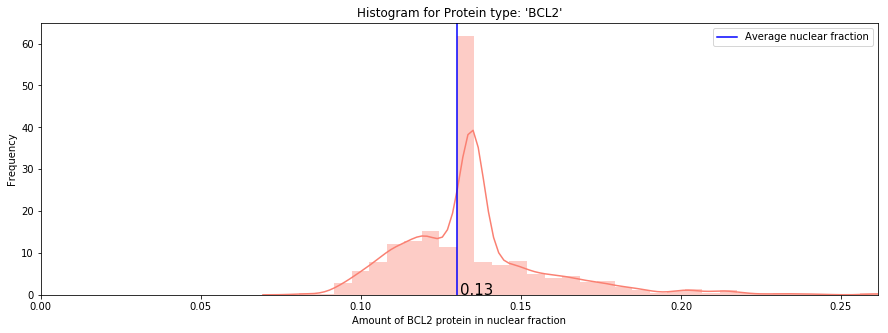

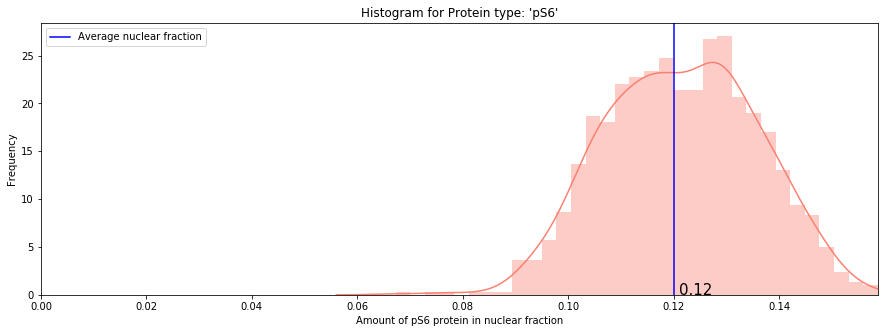

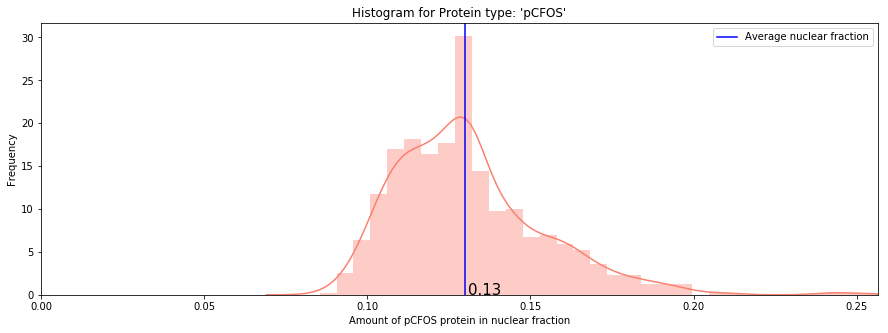

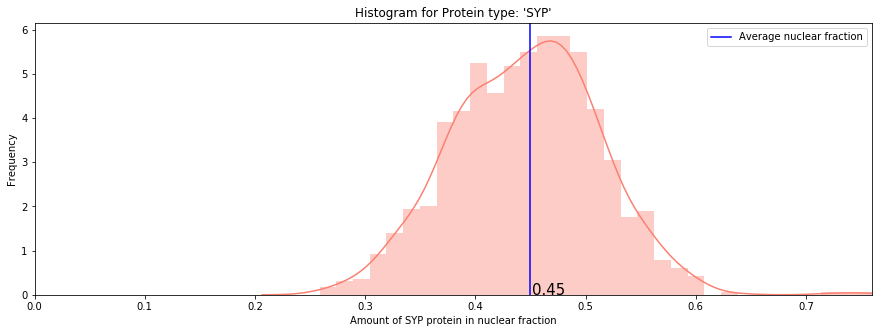

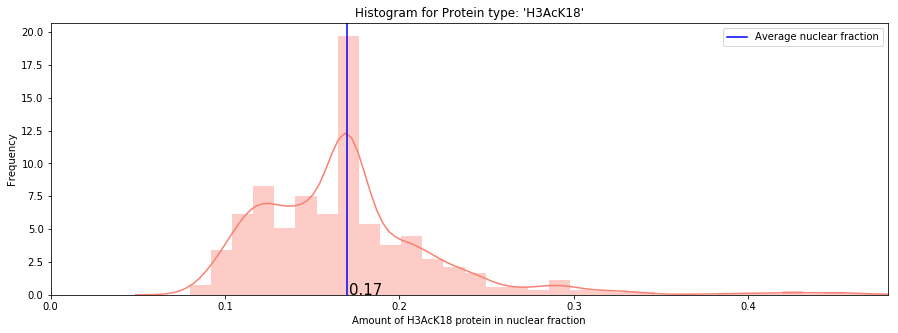

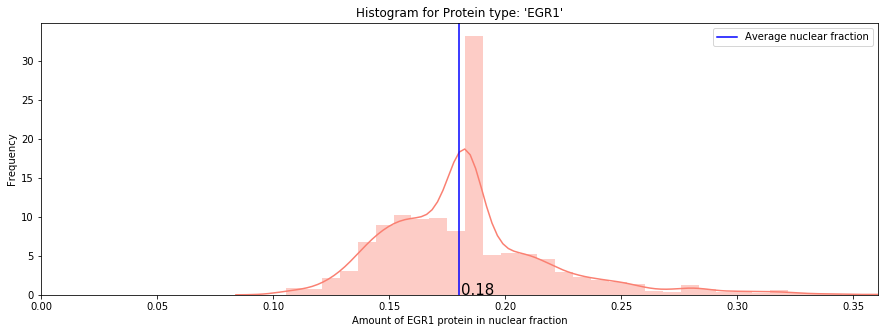

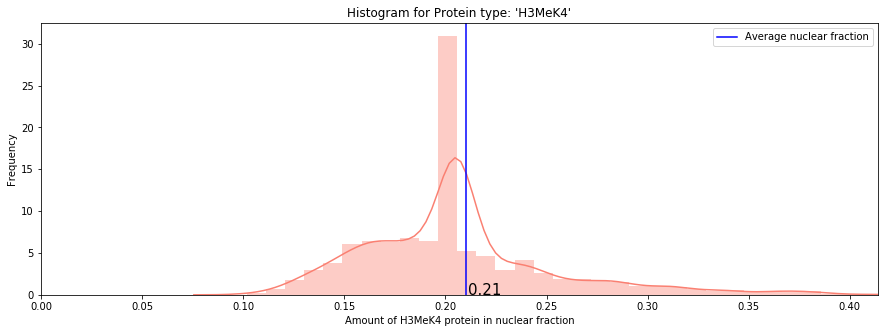

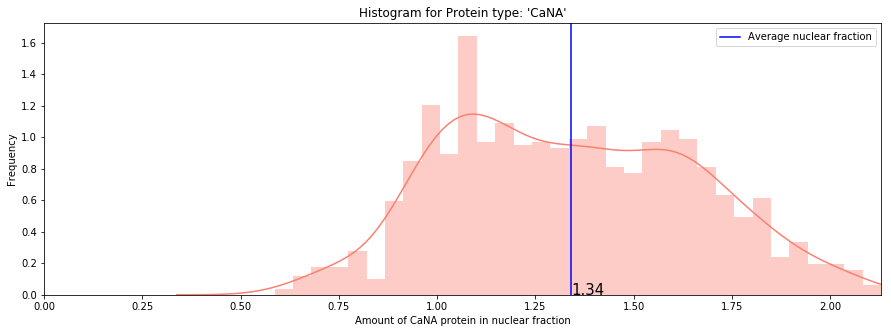

In [15]:
avg = {}
for column in mice_data.columns:
    if str(mice_data[column].dtype) is not 'category':
        a = plot_histogram(column)
        avg[column] = a

The protein with lowest frequency has highest nf-amount, and highest frequency has lowest nf-amount.

# Multivariate Exploration

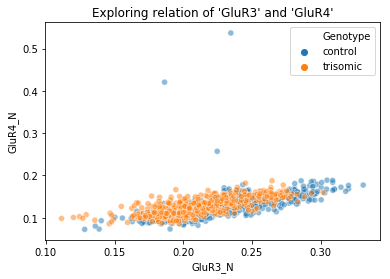

In [16]:
# H1: There exists a linear relationship between 'GluR3' and 'GluR4' .
sns.scatterplot(mice_data['GluR3_N'], mice_data['GluR4_N'], hue = mice_data['Genotype'], alpha = 0.5)
plt.title("Exploring relation of 'GluR3' and 'GluR4'")
plt.show()

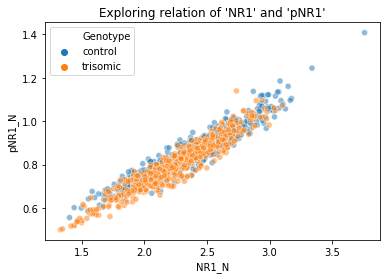

In [17]:
# H2: There exists a linear relationship between 'NR1' and 'pNR1'.
sns.scatterplot(mice_data['NR1_N'], mice_data['pNR1_N'], hue = mice_data['Genotype'], alpha = 0.5)
plt.title("Exploring relation of 'NR1' and 'pNR1'")
plt.show()

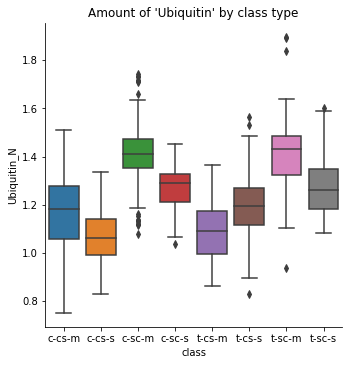

In [18]:
#H3: Which subclass of mouse has highest protein amount of 'Ubiquitin'?
sns.catplot(x = 'class', y = 'Ubiquitin_N', kind = 'box', data = mice_data)
plt.title("Amount of 'Ubiquitin' by class type")
plt.show()

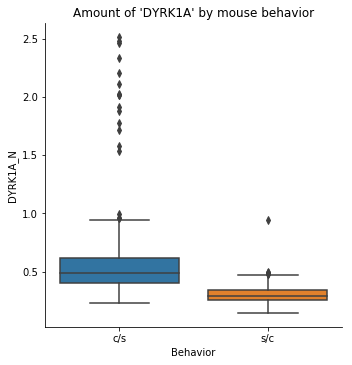

In [19]:
#H4: Which type of behavior influences higher amount of 'DYRK1A' protein?
sns.catplot(x = 'Behavior', y = 'DYRK1A_N', kind = 'box', data = mice_data)
plt.title("Amount of 'DYRK1A' by mouse behavior")
plt.show()

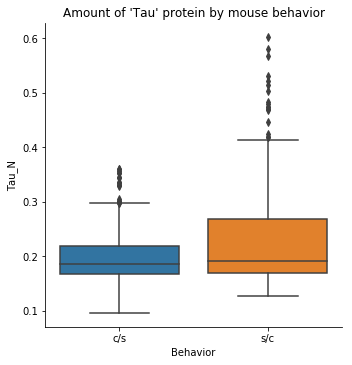

In [20]:
#H5: Which type of behavior influences higher amount of ‘Tau’ protein?
sns.catplot(x = 'Behavior', y = 'Tau_N', kind = 'box', data = mice_data)
plt.title("Amount of 'Tau' protein by mouse behavior")
plt.show()

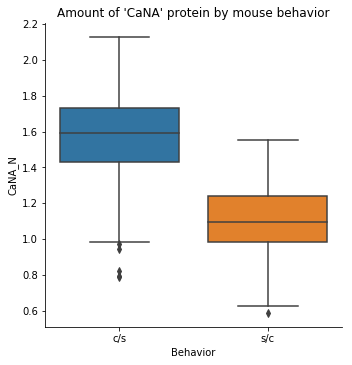

In [22]:
#H6: Which type of behaviour influences higher amount of ‘CaNA’ protein?
sns.catplot(x = 'Behavior', y = 'CaNA_N', kind = 'box', data = mice_data)
plt.title("Amount of 'CaNA' protein by mouse behavior")
plt.show()

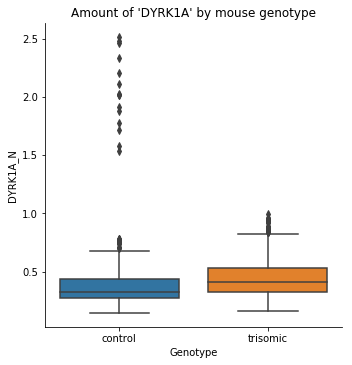

In [21]:
# H7: Which genotype of mice carry higher amount of 'DYRK1A' protein?
sns.catplot(x = 'Genotype', y = 'DYRK1A_N', kind = 'box', data = mice_data)
plt.title("Amount of 'DYRK1A' by mouse genotype")
plt.show()

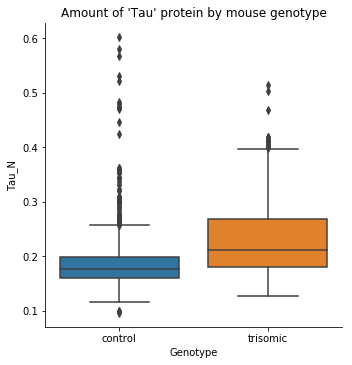

In [23]:
# H8: Which genotype of mice carry higher amount of  ‘Tau’ protein?
sns.catplot(x = 'Genotype', y = 'Tau_N', kind = 'box', data = mice_data)
plt.title("Amount of 'Tau' protein by mouse genotype")
plt.show()

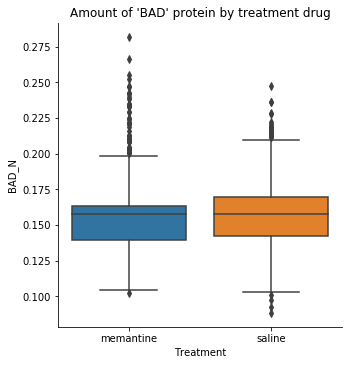

In [24]:
# H9: Which treatment drug influences higher level of 'BAD' protein?
sns.catplot(x = 'Treatment', y = 'BAD_N', kind = 'box', data = mice_data)
plt.title("Amount of 'BAD' protein by treatment drug")
plt.show()

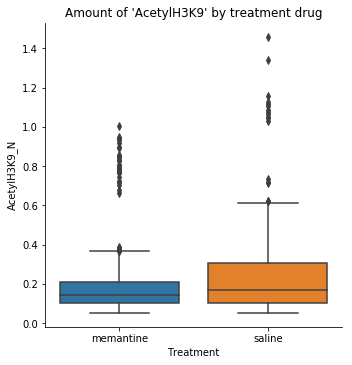

In [25]:
# H10: Which treatment drug influences higher level of ' AcetylH3K9' protein?
sns.catplot(x = 'Treatment', y = 'AcetylH3K9_N', kind = 'box', data = mice_data)
plt.title("Amount of 'AcetylH3K9' by treatment drug")
plt.show()

# Data Modelling

In [26]:
# Label Encoding
labelencoder = LabelEncoder()

for column in ['Genotype', 'Treatment', 'Behavior', 'class']:
    mice_data[column] = labelencoder.fit_transform(mice_data[column])

In [27]:
# checking whether features are encoded
mice_data.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,0,0,0,0
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,0,0,0,0
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,0,0,0,0
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,0,0,0,0
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,0,0,0,0


In [28]:
# Partition into dependent and independent variables
X = mice_data.drop(['Genotype', 'Treatment', 'Behavior', 'class'], axis=1)
y = mice_data['class']

In [29]:
# Scaling the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [30]:
# PArtition into train-test-validation set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [31]:
# Class labels to display for confusion matrix
class_labels = ['c-cs-m', 'c-cs-s', 'c-sc-m', 'c-sc-s',
               't-cs-m', 't-cs-s', 't-sc-m', 't-sc-s']

# Building KNN classifier

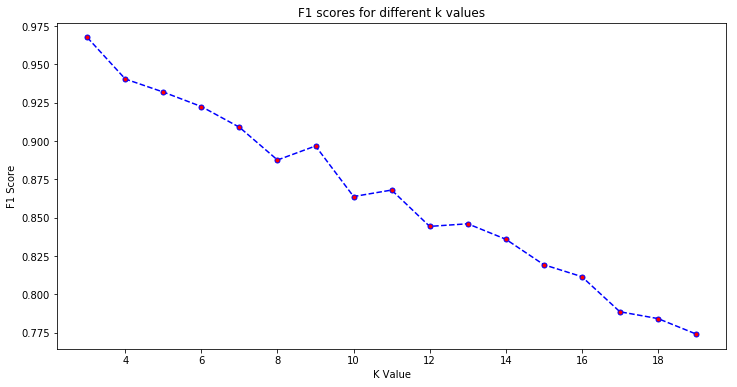

In [32]:
# Looking for optimal k-value
error = []
precision = []
recall=[]
f1 =[]

for i in range(3, 20):  
    clf = KNeighborsClassifier(n_neighbors=i)
    fit = clf.fit(X_train, y_train)
    predicted_labels = clf.predict(X_test)
    error.append(np.mean(predicted_labels != y_test))
    precision_hpt,recall_hpt,fscore_hpt,support_hpt = score(y_test, predicted_labels, average= 'weighted')
    #fscore_hpt = accuracy_score(y_test, predicted_labels)
    f1.append(fscore_hpt)
    
plt.figure(figsize=(12, 6))  

plt.plot(range(3, 20), f1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=5);

plt.title('F1 scores for different k values')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score')
plt.show()
k = f1.index(max(f1))+1

In [33]:
# Building knn classifier
knn_clf = KNeighborsClassifier(n_neighbors = k, 
                           weights = 'uniform', 
                           metric = 'minkowski', p = 2)

kf = KFold(n_splits=10,random_state=0, shuffle=False)
#run the KFlod cross validation
for k, (train_index, test_index) in enumerate(kf.split(X_train)):
 
    X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
     
    knn_clf.fit(X_train1, y_train1)
    print("[fold {0}] score: {1:.5f}".format(k, knn_clf.score(X_test1, y_test1)))

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

[fold 0] score: 1.00000
[fold 1] score: 0.98551
[fold 2] score: 1.00000
[fold 3] score: 0.97101
[fold 4] score: 0.98551
[fold 5] score: 1.00000
[fold 6] score: 1.00000
[fold 7] score: 1.00000
[fold 8] score: 0.95652
[fold 9] score: 1.00000


With k-fold, accuracy of KNN varies from 0.95 to 1.0

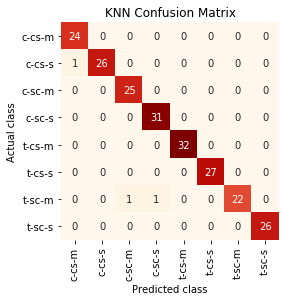

Accuracy:  0.9861111111111112


In [34]:
sns.heatmap(cm, cbar=False, annot=True, square=True, cmap = 'OrRd',
                                    xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('KNN Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy_score(y_test, y_pred))

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        27
           2       0.96      1.00      0.98        25
           3       0.97      1.00      0.98        31
           4       1.00      1.00      1.00        32
           5       1.00      1.00      1.00        27
           6       1.00      0.92      0.96        24
           7       1.00      1.00      1.00        26

   micro avg       0.99      0.99      0.99       216
   macro avg       0.99      0.98      0.99       216
weighted avg       0.99      0.99      0.99       216



# Building Decision Tree classifier

In [36]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy',
                                splitter = 'best',
                                max_features = 'auto',
                                max_depth = 50, 
                                min_samples_split = 3)

kf = KFold(n_splits=10, random_state=0, shuffle=False)
#run the KFlod cross validation
for k, (train_index, test_index) in enumerate(kf.split(X_train)):
 
    X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
     
    dt_clf.fit(X_train1, y_train1)
    print("[fold {0}] score: {1:.5f}".format(k, dt_clf.score(X_test1, y_test1)))

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

[fold 0] score: 0.84286
[fold 1] score: 0.75362
[fold 2] score: 0.82609
[fold 3] score: 0.68116
[fold 4] score: 0.82609
[fold 5] score: 0.81159
[fold 6] score: 0.82609
[fold 7] score: 0.78261
[fold 8] score: 0.72464
[fold 9] score: 0.75362


With k-fold, accuracy of Decision Tree varies from 0.62 to 0.84

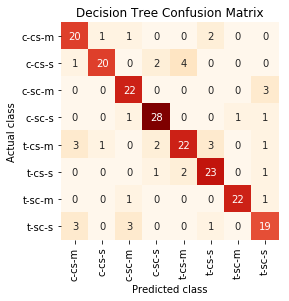

Accuracy:  0.8148148148148148


In [37]:
sns.heatmap(cm, cbar=False, annot=True, square=True, cmap = 'OrRd',
                                    xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Decision Tree Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy_score(y_test, y_pred))

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        24
           1       0.91      0.74      0.82        27
           2       0.79      0.88      0.83        25
           3       0.85      0.90      0.88        31
           4       0.79      0.69      0.73        32
           5       0.79      0.85      0.82        27
           6       0.96      0.92      0.94        24
           7       0.73      0.73      0.73        26

   micro avg       0.81      0.81      0.81       216
   macro avg       0.82      0.82      0.82       216
weighted avg       0.82      0.81      0.81       216



# Comparing classifiers over Validation set data

In [39]:
knn_y_pred = knn_clf.predict(X_val)
dt_y_pred = dt_clf.predict(X_val)

print("Knn Accuracy: ", accuracy_score(y_val, knn_y_pred))
print("Decision Tree Accuracy: ", accuracy_score(y_val, dt_y_pred))

Knn Accuracy:  0.9710982658959537
Decision Tree Accuracy:  0.7572254335260116
